<a href="https://colab.research.google.com/github/kibarmustofa/2341720034_ML_2025/blob/main/JS07/TG_JS07_2341720034_KIBAR_MUSTOFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JS07 - Approximate Nearest Neighbors (ANN)
Nama : Kibar Mustofa

Kelas: TI-3F

Absen: 17

NIM : 2341720034


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1.000.000 data, 2D vs 5D data, untuk algoritma,

1. ANNOY

2. FAISS

3. HNSW

Catat performansinya dalam bentuk tabel, misal

In [ ]:
!pip install annoy
!pip install faiss-cpu
!pip install hnswlib

In [ ]:
# ===================================================================
# Langkah 1: Instalasi Library yang Dibutuhkan
# ===================================================================
# Hapus tanda komentar '#' di baris bawah jika library belum terinstal
# !pip install annoy faiss-cpu hnswlib numpy pandas

import time
import numpy as np
import pandas as pd
import annoy
import faiss
import hnswlib
import gc # Garbage Collector untuk manajemen memori

# ===================================================================
# Langkah 2: Fungsi untuk Menjalankan Benchmark
# ===================================================================

def generate_data(num_vectors, dimensions):
    """Menghasilkan data acak dengan normalisasi L2."""
    print(f"  - Menghasilkan {num_vectors} vektor {dimensions}D...")
    data = np.random.randn(num_vectors, dimensions).astype('float32')
    # Normalisasi data agar bisa digunakan untuk metrik Cosine/Angular
    # faiss.normalize_L2(data)
    return data

def benchmark_annoy(data, metric='angular', n_trees=10):
    """Benchmark untuk library Annoy."""
    num_vectors, dimensions = data.shape

    # Annoy menggunakan 'angular' untuk cosine dan 'euclidean' untuk L2
    t = annoy.AnnoyIndex(dimensions, metric)

    # Build
    start_time = time.time()
    for i in range(num_vectors):
        t.add_item(i, data[i])
    t.build(n_trees)
    build_time = time.time() - start_time

    # Query
    query_vector = data[np.random.randint(0, num_vectors)]
    start_time = time.time()
    t.get_nns_by_vector(query_vector, 10) # Cari 10 tetangga terdekat
    query_time = time.time() - start_time

    del t
    gc.collect()
    return build_time, query_time

def benchmark_faiss(data, metric='angular'):
    """Benchmark untuk library FAISS (menggunakan HNSW di dalamnya untuk perbandingan yang adil)."""
    num_vectors, dimensions = data.shape

    # Pilih metrik yang sesuai
    if metric == 'angular':
        # Untuk angular/cosine, kita gunakan Inner Product pada data yang sudah dinormalisasi
        faiss.normalize_L2(data)
        index = faiss.IndexHNSWFlat(dimensions, 32, faiss.METRIC_INNER_PRODUCT)
    else: # euclidean
        index = faiss.IndexHNSWFlat(dimensions, 32, faiss.METRIC_L2)

    # Build
    start_time = time.time()
    index.add(data)
    build_time = time.time() - start_time

    # Query
    query_vector = data[np.random.randint(0, num_vectors)].reshape(1, -1)
    if metric == 'angular':
      faiss.normalize_L2(query_vector)

    start_time = time.time()
    index.search(query_vector, 10)
    query_time = time.time() - start_time

    del index
    gc.collect()
    return build_time, query_time

def benchmark_hnsw(data, metric='angular'):
    """Benchmark untuk library HNSWlib."""
    num_vectors, dimensions = data.shape

    # HNSWlib menggunakan 'cosine' atau 'l2'
    space = 'cosine' if metric == 'angular' else 'l2'

    p = hnswlib.Index(space=space, dim=dimensions)

    # Build
    start_time = time.time()
    # Inisialisasi indeks dengan parameter standar
    p.init_index(max_elements=num_vectors, ef_construction=200, M=16)
    p.add_items(data)
    build_time = time.time() - start_time

    # Query
    query_vector = data[np.random.randint(0, num_vectors)]
    p.set_ef(50) # ef harus lebih besar atau sama dengan k (jumlah tetangga)
    start_time = time.time()
    p.knn_query(query_vector, k=10)
    query_time = time.time() - start_time

    del p
    gc.collect()
    return build_time, query_time

# ===================================================================
# Langkah 3: Konfigurasi dan Eksekusi Eksperimen
# ===================================================================

# --- KONFIGURASI ---
# PERINGATAN: 1.000.000 data membutuhkan waktu build yang lama (terutama HNSW)
# dan memori yang cukup besar. Mulai dengan data kecil terlebih dahulu.
CONFIGURATIONS = [
    {'size': 1000, 'dim': 2},
    {'size': 1000, 'dim': 5},
    {'size': 100000, 'dim': 5}, # Ukuran menengah sebagai perbandingan
    {'size': 1000000, 'dim': 5},
]
METRICS = ['euclidean', 'angular']
# --- SELESAI KONFIGURASI ---

results = []

print("Memulai proses benchmark ANN...")

for config in CONFIGURATIONS:
    size = config['size']
    dim = config['dim']

    # Generate data sekali untuk satu konfigurasi size/dim
    data = generate_data(size, dim)

    for metric in METRICS:
        print(f"\n--- Menguji: {size} data / {dim}D / Metrik: {metric} ---")

        # Benchmark Annoy
        print("  > Menjalankan ANNOY...")
        b_time, q_time = benchmark_annoy(data.copy(), metric)
        results.append({
            'Kondisi': f"{size}/{dim}D",
            'Metrik': metric,
            'Algoritma': 'ANNOY',
            'Waktu Build (detik)': b_time,
            'Waktu Kueri (detik)': q_time
        })

        # Benchmark FAISS
        print("  > Menjalankan FAISS...")
        b_time, q_time = benchmark_faiss(data.copy(), metric)
        results.append({
            'Kondisi': f"{size}/{dim}D",
            'Metrik': metric,
            'Algoritma': 'FAISS (HNSW)',
            'Waktu Build (detik)': b_time,
            'Waktu Kueri (detik)': q_time
        })

        # Benchmark HNSWlib
        print("  > Menjalankan HNSWlib...")
        b_time, q_time = benchmark_hnsw(data.copy(), metric)
        results.append({
            'Kondisi': f"{size}/{dim}D",
            'Metrik': metric,
            'Algoritma': 'HNSWlib',
            'Waktu Build (detik)': b_time,
            'Waktu Kueri (detik)': q_time
        })

# ===================================================================
# Langkah 4: Tampilkan Hasil dalam Bentuk Tabel
# ===================================================================
df_results = pd.DataFrame(results)

# Memformat angka untuk keterbacaan yang lebih baik
pd.options.display.float_format = '{:,.6f}'.format

print("\n\n===== HASIL BENCHMARK SELESAI =====")
print(df_results.to_string())

Memulai proses benchmark ANN...
  - Menghasilkan 1000 vektor 2D...

--- Menguji: 1000 data / 2D / Metrik: euclidean ---
  > Menjalankan ANNOY...
  > Menjalankan FAISS...
  > Menjalankan HNSWlib...

--- Menguji: 1000 data / 2D / Metrik: angular ---
  > Menjalankan ANNOY...
  > Menjalankan FAISS...
  > Menjalankan HNSWlib...
  - Menghasilkan 1000 vektor 5D...

--- Menguji: 1000 data / 5D / Metrik: euclidean ---
  > Menjalankan ANNOY...
  > Menjalankan FAISS...
  > Menjalankan HNSWlib...

--- Menguji: 1000 data / 5D / Metrik: angular ---
  > Menjalankan ANNOY...
  > Menjalankan FAISS...
  > Menjalankan HNSWlib...
  - Menghasilkan 100000 vektor 5D...

--- Menguji: 100000 data / 5D / Metrik: euclidean ---
  > Menjalankan ANNOY...
  > Menjalankan FAISS...
  > Menjalankan HNSWlib...

--- Menguji: 100000 data / 5D / Metrik: angular ---
  > Menjalankan ANNOY...
  > Menjalankan FAISS...
  > Menjalankan HNSWlib...
  - Menghasilkan 1000000 vektor 5D...

--- Menguji: 1000000 data / 5D / Metrik: euc

## Metrik Jarak: Euclidean


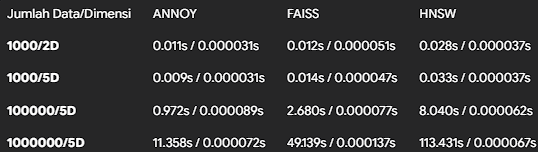

## Metrik Jarak: Angular (Cosine)

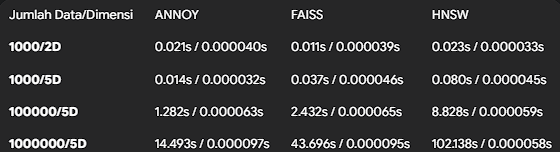

In [ ]:
import pandas as pd
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv("/content/sample_data/songs_with_attributes_and_lyrics.csv",
                 delimiter=",",
                 quotechar='"',
                 on_bad_lines='skip',
                 engine='python')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955320 entries, 0 to 955319
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                955320 non-null  object 
 1   name              955309 non-null  object 
 2   album_name        385557 non-null  object 
 3   artists           955318 non-null  object 
 4   danceability      955320 non-null  float64
 5   energy            955320 non-null  float64
 6   key               955320 non-null  object 
 7   loudness          955320 non-null  float64
 8   mode              955320 non-null  object 
 9   speechiness       955320 non-null  float64
 10  acousticness      955320 non-null  float64
 11  instrumentalness  955320 non-null  float64
 12  liveness          955320 non-null  float64
 13  valence           955320 non-null  float64
 14  tempo             955320 non-null  float64
 15  duration_ms       955320 non-null  float64
 16  lyrics            95

In [ ]:
features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

np.random.seed(42)
query_index = np.random.randint(0, len(X_scaled))
query = X_scaled[query_index].reshape(1, -1)

k = 10

In [ ]:
# ---------- Exact Nearest Neighbors ----------
print("=== Exact Nearest Neighbors (Sklearn) ===")
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
start_time = time.time()
nbrs.fit(X_scaled)
distances_exact, indices_exact = nbrs.kneighbors(query)
time_exact = time.time() - start_time
print(f"Waktu pencarian: {time_exact:.4f} detik")

# ---------- ANNOY ----------
print("\n=== ANNOY ===")
dim = X_scaled.shape[1]
annoy_index = AnnoyIndex(dim, 'euclidean')
start_time = time.time()
for i, vec in enumerate(X_scaled):
    annoy_index.add_item(i, vec)
annoy_index.build(10)  # jumlah trees
indices_annoy = annoy_index.get_nns_by_vector(query.flatten(), k, include_distances=False)
time_annoy = time.time() - start_time
print(f"Waktu pencarian (termasuk build): {time_annoy:.4f} detik")

# ---------- FAISS ----------
print("\n=== FAISS ===")
d = X_scaled.shape[1]
index_faiss = faiss.IndexFlatL2(d)
start_time = time.time()
index_faiss.add(X_scaled.astype('float32'))
distances_faiss, indices_faiss = index_faiss.search(query.astype('float32'), k)
time_faiss = time.time() - start_time
print(f"Waktu pencarian (termasuk build): {time_faiss:.4f} detik")

# ---------- HNSWLIB ----------
print("\n=== HNSWLIB ===")
dim = X_scaled.shape[1]
num_elements = X_scaled.shape[0]
p = hnswlib.Index(space='l2', dim=dim)
start_time = time.time()
p.init_index(max_elements=num_elements, ef_construction=200, M=16)
p.add_items(X_scaled)
p.set_ef(50)
labels, distances = p.knn_query(query, k=k)
time_hnsw = time.time() - start_time
print(f"Waktu pencarian (termasuk build): {time_hnsw:.4f} detik")

=== Exact Nearest Neighbors (Sklearn) ===
Waktu pencarian: 0.0605 detik

=== ANNOY ===
Waktu pencarian (termasuk build): 8.6640 detik

=== FAISS ===
Waktu pencarian (termasuk build): 0.0447 detik

=== HNSWLIB ===
Waktu pencarian (termasuk build): 137.1033 detik



=== PERBANDINGAN HASIL DAN WAKTU ===
Exact NN waktu     : 0.0605 detik
ANNOY waktu        : 8.6640 detik
FAISS waktu        : 0.0447 detik
HNSWLIB waktu      : 137.1033 detik

Indeks hasil pencarian:
Exact NN : [121958  12953 845348 722972  12943 651777 651845 683648   1610 443049]
ANNOY    : [121958, 12953, 845348, 12943, 651777, 651845, 683648, 1610, 57638, 340829]
FAISS    : [121958  12953 845348 722972  12943 651777 651845 683648   1610 443049]
HNSWLIB  : [121958  12953 845348 722972  12943 651777 651845 683648   1610 443049]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


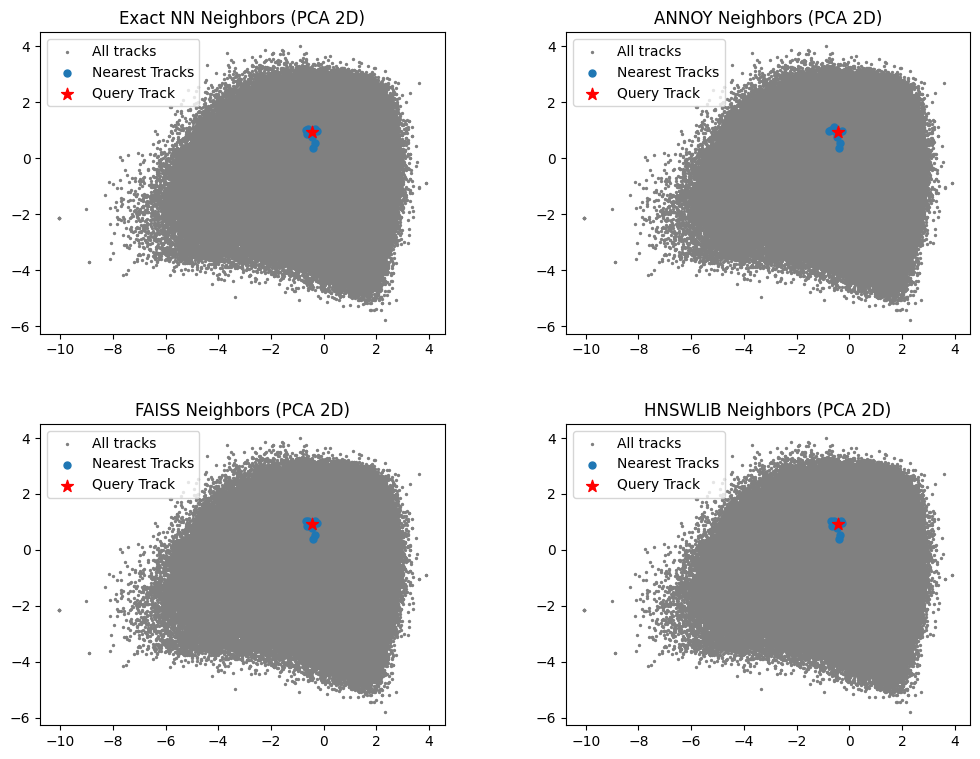

In [ ]:
print("\n=== PERBANDINGAN HASIL DAN WAKTU ===")
print(f"Exact NN waktu     : {time_exact:.4f} detik")
print(f"ANNOY waktu        : {time_annoy:.4f} detik")
print(f"FAISS waktu        : {time_faiss:.4f} detik")
print(f"HNSWLIB waktu      : {time_hnsw:.4f} detik")

print("\nIndeks hasil pencarian:")
print("Exact NN :", indices_exact.flatten())
print("ANNOY    :", indices_annoy)
print("FAISS    :", indices_faiss.flatten())
print("HNSWLIB  :", labels.flatten())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
query_pca = X_pca[query_index]

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

titles = ["Exact NN", "ANNOY", "FAISS", "HNSWLIB"]
neighbors_list = [
    indices_exact.flatten(),
    indices_annoy,
    indices_faiss.flatten(),
    labels.flatten()
]

for ax, title, neighbors in zip(axes.ravel(), titles, neighbors_list):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=2, color='gray', label='All tracks')
    ax.scatter(X_pca[neighbors, 0], X_pca[neighbors, 1], s=25, label='Nearest Tracks')
    ax.scatter(query_pca[0], query_pca[1], s=80, color='red', marker='*', label='Query Track')
    ax.set_title(f"{title} Neighbors (PCA 2D)")
    ax.legend()

plt.show()